In [1]:
import gym
import numpy as np
import random
import os
import time
import math
import sys
from collections import deque
from collections import defaultdict
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings(action='ignore')

In [2]:
GAMMA         = 0.98
LEARNING_RATE = 0.0005
BUFFER_LIMIT  = 50000
BATCH_SIZE    = 32
EPISODE_NUMBER = 1000
RANDOM_SEED = 43

In [3]:
#SEED 고정
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [4]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = deque(maxlen=BUFFER_LIMIT)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        state_lst, action_lst, reward_lst, next_state_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            state, action, reward, next_state, done_mask = transition
            state_lst.append(state)
            action_lst.append([action])
            reward_lst.append([reward])
            next_state_lst.append(next_state)
            done_mask_lst.append([done_mask])
 
        return torch.tensor(state_lst, dtype=torch.float), torch.tensor(action_lst), torch.tensor(reward_lst), torch.tensor(next_state_lst, dtype=torch.float), torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [5]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        #random.seed(RANDOM_SEED)
        coin = random.random()
        if coin < epsilon:
          #random.seed(RANDOM_SEED)
          return random.randint(0,1)
        else :
          return out.argmax().item()

In [6]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        state, action, reward, next_state, done_mask = memory.sample(BATCH_SIZE)
 
        q_out = q(state)
        q_action = q_out.gather(1, action)

        next_max_q = q_target(next_state).max(1)[0].unsqueeze(1)
        target = reward + GAMMA * next_max_q * done_mask
        
        #스무딩 L1 loss 이용
        loss = F.smooth_l1_loss(q_action, target)
        
        # 자동 백프로퍼게이션
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [7]:
env = gym.make("CartPole-v1")
env.seed(RANDOM_SEED)

[43]

In [8]:
env.action_space.seed(RANDOM_SEED) # 환경 변화를 고정시켜서 다시 재현 가능하도록 해줌

[43]

In [9]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(2)


In [10]:
print("State Space {}".format(env.observation_space))

State Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [13]:
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()
optimizer = optim.Adam(q.parameters(), lr=LEARNING_RATE)

first_Score_500_episode_number = 0.0
Score_500_episode_count = 0
cum_reward = 0.0
scores = []

for i_episode in range(1, EPISODE_NUMBER+1):
  epsilon = max(0.01, 0.08 - 0.01*(i_episode/200))
  state = env.reset()
  env.seed(RANDOM_SEED)
  done = False
  
  while not done:
      action = q.sample_action(torch.from_numpy(state).float(), epsilon)      
      next_state, reward, done, _ = env.step(action)
      done_mask = 0.0 if done else 1.0
      memory.put((state,action,reward/100.0,next_state, done_mask))
      state = next_state
      cum_reward += reward

      if done:
        scores.append(cum_reward)

        # 500 이상일 경우 최대 점수 획득한 것임
        if cum_reward == 500.0:
          Score_500_episode_count = Score_500_episode_count + 1
          if Score_500_episode_count == 1:
            first_Score_500_episode_number = i_episode + 1
        break
      
  if memory.size()>2000:
      train(q, q_target, memory, optimizer)

  q_target.load_state_dict(q.state_dict())
  print("에피소드 :{}, 점수 : {:.1f}, 입실론 : {:.1f}%".format(i_episode, cum_reward, epsilon*100))
  cum_reward = 0.0 # 점수 초기화

에피소드 :1, 점수 : 8.0, 입실론 : 8.0%
에피소드 :2, 점수 : 10.0, 입실론 : 8.0%
에피소드 :3, 점수 : 10.0, 입실론 : 8.0%
에피소드 :4, 점수 : 8.0, 입실론 : 8.0%
에피소드 :5, 점수 : 8.0, 입실론 : 8.0%
에피소드 :6, 점수 : 8.0, 입실론 : 8.0%
에피소드 :7, 점수 : 8.0, 입실론 : 8.0%
에피소드 :8, 점수 : 8.0, 입실론 : 8.0%
에피소드 :9, 점수 : 9.0, 입실론 : 8.0%
에피소드 :10, 점수 : 8.0, 입실론 : 8.0%
에피소드 :11, 점수 : 8.0, 입실론 : 7.9%
에피소드 :12, 점수 : 8.0, 입실론 : 7.9%
에피소드 :13, 점수 : 8.0, 입실론 : 7.9%
에피소드 :14, 점수 : 9.0, 입실론 : 7.9%
에피소드 :15, 점수 : 8.0, 입실론 : 7.9%
에피소드 :16, 점수 : 8.0, 입실론 : 7.9%
에피소드 :17, 점수 : 8.0, 입실론 : 7.9%
에피소드 :18, 점수 : 8.0, 입실론 : 7.9%
에피소드 :19, 점수 : 8.0, 입실론 : 7.9%
에피소드 :20, 점수 : 8.0, 입실론 : 7.9%
에피소드 :21, 점수 : 8.0, 입실론 : 7.9%
에피소드 :22, 점수 : 10.0, 입실론 : 7.9%
에피소드 :23, 점수 : 8.0, 입실론 : 7.9%
에피소드 :24, 점수 : 8.0, 입실론 : 7.9%
에피소드 :25, 점수 : 9.0, 입실론 : 7.9%
에피소드 :26, 점수 : 8.0, 입실론 : 7.9%
에피소드 :27, 점수 : 10.0, 입실론 : 7.9%
에피소드 :28, 점수 : 8.0, 입실론 : 7.9%
에피소드 :29, 점수 : 10.0, 입실론 : 7.9%
에피소드 :30, 점수 : 8.0, 입실론 : 7.8%
에피소드 :31, 점수 : 8.0, 입실론 : 7.8%
에피소드 :32, 점수 : 8.0, 입실론 : 7.8%
에피소드 :33, 점수

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline 

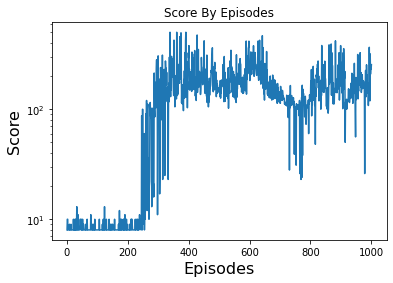

In [15]:
f = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Score By Episodes')
plt.xlabel("Episodes", fontsize=16)
plt.ylabel('Score',fontsize=16)
plt.yscale('log')
plt.show()

In [16]:
#처음 500점 나온 에피소드 넘버
print(first_Score_500_episode_number)
print('처음 500점 나온 에피소드 넘버 : {}'.format(first_Score_500_episode_number))

#최고 500점 나온 개수 횟수
print(Score_500_episode_count)
print('최고 500점 나온 개수 횟수 : {}'.format(Score_500_episode_count))

340
처음 500점 나온 에피소드 넘버 : 340
3
최고 500점 나온 개수 횟수 : 3


In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 15.2 MB/s 


In [24]:
import base64, io

# 코랩 비디오 레코딩 라이브러리
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

# 구글 코랩 드라이브 마운트 후 video 폴더를 생성한후 해당 펑션 콜하면 됨
def show_video(env_name):
    mp4list = glob.glob('/content/gdrive/MyDrive/video/*.mp4')
    if len(mp4list) > 0:
        mp4 = '/content/gdrive/MyDrive/video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# 구글 코랩 드라이브 마운트 후 video 폴더를 생성한후 해당 펑션 콜하면 됨
def show_video_of_model(env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="/content/gdrive/MyDrive/video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    while not done:
        vid.capture_frame()
        action = q.sample_action(torch.from_numpy(state).float(), epsilon)      
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break        
    env.close()

In [22]:
#마지막 상태의 카트폴 저장
show_video_of_model("CartPole-v1")

In [26]:
#카트폴 보여주기
show_video("CartPole-v1")